# [MICRO-452:][MICRO-452] Project Report - Groupe 19

**Authors:** Neil Chennoufi, Christopher Hémon, Jérémy Mayoraz, Arthur Rémondeau  
**Supervisors:** Prof. Francesco Mondada, Laila El-Hamamsy  
**Due date:** 07.12.2020

[MICRO-452]: https://moodle.epfl.ch/pluginfile.php/2727652/mod_resource/content/3/Week%209%20-%20Project%20Presentation.pdf

## Table of Contents
<ol>
<li>Introduction</li>
<li>Vision</li>
<li>Global Navigation</li>
<li>Local Navigation</li>
<li>Extended Kalman Filter</li>
<li>Motion Control</li>
<li>Main</li>
<li>Conclusion</li>
</ol>

## 1. Introduction

We are a group of 4 Robotics students who are all members of the Association [Festival Balélec][Balélec]. As such, when we learned that we were meant to program a robot trying to reach an objective while avoiding fixed and mobile obstacles, we immediatly thought of our poor attendees who, every year, fight to find their friends in a sea of courtfoods, trees, fences and other mobile party people. This is why our original goal was to simulate this very challenge! Using the festival map as a background and the faces of our friends as the goal, we attempted to use pattern recognition to detect the various fixed obstacles we put out: trees, stands, stages... Obviously this proved to be much too complexe simply on an image recognition standpoint to implement this in just 3 weeks, but the idea anchored some of the fundamental principles of our environment.

Our simulation environment is a white background on which lay black, sharp, flat obstacles, a blue target, and red and green identifier marks on the Thymio. A fixed overhead `camera` is used to identify the various markers through color scanning, hence the distinct colors. Path finding occurs using the `sharp edges algorithm` seen in the course, hence the sharp edged black obstacles and then the thymio sets off on the planned course to its objective. At certain checkpoints, the thymio will compare its expected position to that measured by the camera using an extended kalman filter. The final result is a bit simplified compared to our initial ambitions as the filter implementation proved to be much more complexe than expected. 3D object obstacles can be introduced onto the path that are detected by the thymio's on board sensors. Once the obstacle is avoided, camera data is used to relocate the thymio and continue on its course to the objective.

[Balélec]:https://balelec.ch/en/

To ease the following report and the examples and demonstrations, we will proceed to the importations needed for each code cell.

### Import

In [1]:
import os
import sys

sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import time
import math
import cv2
import numpy as np
import serial
import camera
import Extended_Kalman_Filter
import global_avoidance
import local_avoidance
import RepeatedTimer
import utilsRobot
import matplotlib.pyplot as plt

from Thymio import Thymio

### Constants

In [2]:
DISTANCE_TOL=20
ANGLE_TOL=3/180*math.pi

DISTANCE_WHEELS=95 #distance between the wheels (in mm)
CALIBRATE_FACTOR=8/25 #Empirical factor found to get an accurate speed estimation.
ROBOT_LENGTH=100

D_REAL = 83         #real distance in mm between the two identifying points on the Thymio

EXT_SPEED=150       #Speed of the farthest wheel from the obstacle during local avoidance
INT_SPEED=120       #Speed of the closest wheel from the obstacle during local avoidance

LA_INCREMENT=3      
LA_MOVE_TIME=4
LA_SPEED=20

FORWARD_SPEED=190
TURNING_SPEED=70

ERODE_FACTOR=40
ERODE_FACTOR_CONNECTION_RATIO=0.5

## 2. Vision

In our project, thymio vision is provided by a fixed overhead camera that is at first used to compute the system's initial situation. Through basic image filtering using [open cv][cv2], we can find the color coded ojective and the thymio's position and angle thanks to the two colored markers placed on either side of the robot. These markers were strategically placed in order to have the measured robot position around the center of rotation. The line connecting the markers is perpendicular to the front facing axis of the thymio. We use this line to calculate the thymio state axis with respect to the picture frame.  

Once Thymio's position and objective position are found within the frame, we detect our fixed obstacles with a black pixel filter. The obstacles need to have sharp edges in order for the global avoidance path finding algorithm to function, as we will see later.

Since system vision is a key element in both the global avoidance algorithm as well as for general system motion control, we directly included the appropriate vision functions in each class rather than putting them in their own seperate class.

[cv2]: https://github.com/opencv/opencv

### Finding the robot and the goal

Prior to finding the path, we need to find the starting point, aka the robot, and the goal. To do so, we used colored papers : one on each side of the Thymio, above the wheels, and one to represent the objective.

The function `find_center_color` uses the HSV format and creates a mask of the original image, keeping only the pixels that are in the bound defined by lower and upper white. If the bounds are defined correcly, only one dot is found.

We then look for the contour and center of this dot using the `cv2.findContours` and the `cv2.moments` functions.
Using these functions with the right bounds, we can identify the coordinates of the green and blue dots, from which we can obtain the coordinates of the robot and its angle. The red dot gives us the goal.
  
We also create a patched image where we add a white spot on the colored papers, this is to ease the obstacle finding done later.

Here is an example of this algorithm at work :

In [3]:
def find_center_color(img, lower, upper,  blur_factor=11):
    '''
    Function used to determine the center of the colored dots. These center will be used
    in 'find_robot' to process the coordinates of the robot.

    Input: - Image       : 'img' is a picture taken as a top view of the setup.
           - Lower       : lower intensity threshold for the color.
           - Upper       : upper intensity threshold for the color.
           - Blur factor : coefficient of bluriness.

    Output: - Center coordinates of the colored dot.
            - Mask excluding the colored dot.
    '''
    #prepare the picture to find the colored dot.
    blur_image=cv2.bilateralFilter(img,20,40,10)
    hsv = cv2.cvtColor(blur_image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    _, mask = cv2.threshold(cv2.blur(mask, (blur_factor, blur_factor)),50,255,cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(np.uint8(mask),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    #find contours of corners
    middles = []
    for c in contours:
        # calculate moments for each contour
        M = cv2.moments(c)
        # calculate x, y coordinate of center
        if M["m00"]==0:
            #print("WARNING: Error with find one corners center")
            continue
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        middles.append((cX, cY))
    return middles[0], mask


In [4]:
def find_goal(image):
    """
    Function used to find the goal of the robot

    Input : -image : goal that needs to be found

    Outputs : -goal_coords : coordinates of the goal
              -patched_map : map without the goal (we only keep the coordinates so that the goal is not considered an obstacle)    
    """
    img=image.copy()
    lower_red = np.array([165 , 90, 120])
    upper_red = np.array([185, 190, 230])

    goal_coords, mask=find_center_color(img, lower_red, upper_red)

    mask=cv2.bitwise_not(cv2.dilate(mask, np.ones((4,4),np.uint8)))
    patched_map =cv2.bitwise_not(cv2.bitwise_and(cv2.bitwise_not(img), cv2.bitwise_not(img), mask = mask))
    return goal_coords, patched_map

def find_robot(image):
    '''
    Function used to determine the coordinates of the robot.

    Input: - Image : picture taken as a top view of the setup.

    Outputs: - Success     : boolean expressing if the robot was successfully located.
                - Coordinates : array (x,y) of the found coordinates of the robot.
                - Angle       : computed angle of the robot.
                - 'img'       : initial image to which a filter for the colored dots was applied.
    '''
    img=image.copy()
    #sets up the lower and upper threshold of the colored dots.
    lower_green = np.array([65 , 110, 40])
    upper_green = np.array([105, 155, 120])
    lower_blue = np.array([90 , 160, 80])
    upper_blue= np.array([110, 250, 200])

    #computes the center of the dots.
    center_green, green_mask=find_center_color(img, lower_green, upper_green)
    center_blue, red_mask=find_center_color(img, lower_blue, upper_blue)

    angle = math.atan2((center_blue[1]-center_green[1]),(center_blue[0]-center_green[0]))+math.pi/2
    if angle>math.pi:
        angle-=2*math.pi

    #applies the masks.
    green_mask=cv2.bitwise_not(cv2.dilate(green_mask, np.ones((4,4),np.uint8)))
    img = cv2.bitwise_and(cv2.bitwise_not(img), cv2.bitwise_not(img), mask = green_mask)
    red_mask=cv2.bitwise_not(cv2.dilate(red_mask, np.ones((4,4),np.uint8)))
    img = cv2.bitwise_not(cv2.bitwise_and(img, img, mask = red_mask))

    #returns the center coordinates, the angle and the masked image.
    return (round((center_blue[0]+center_green[0])/2),round((center_blue[1]+center_green[1])/2)), angle, img


The following diagram shows in detail how we compute the location of the robot from image recognition. As stated before, first we find the two identifying colored markers using image recognition, then we get the center of these markers. The middle of the line linking the center of both colored markers is what we define as our robot's position. This is the pixel position with respect to the x and y axis as defined by our camera's frame.  

From the center line and the center point, we can estimate the facing angle of the robot with respect to the x axis. This is the angle we feed into the system state vector and the one that is used to calculate the change in angle needed between goal markers.  

It is also at this point that we recalibrate our pixel to millimeter scale. Since we know the real life distance between the markers, noted as `D_REAL`, we can easily compute our scaling factor in pxl/mm.

The following diagram illustrates what is written above :

<img src="images/Thymio Axis.jpg" width=50%>


On the first picture, we notice a blue dot computed for the center of rotation of the thymio and a red dot for the objective.

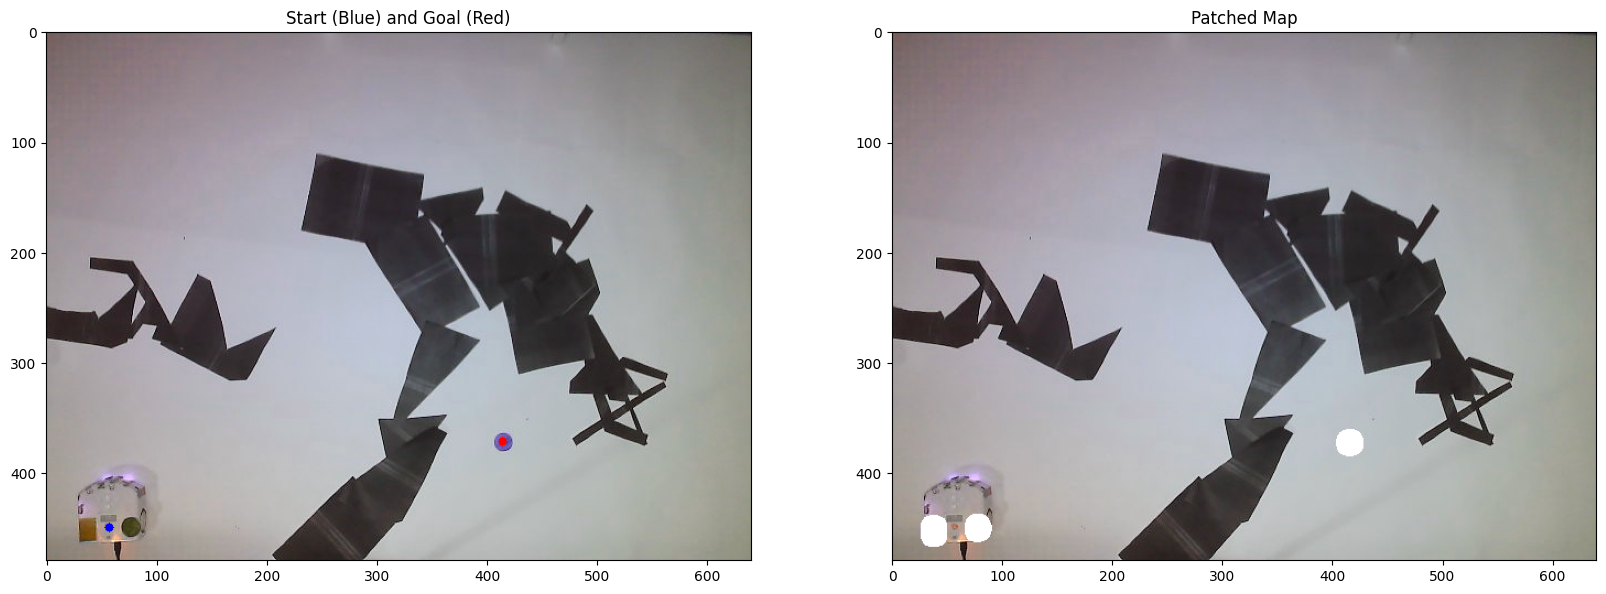

In [5]:
img=cv2.imread('images/layout.jpg')

goal_coords, patched_img=find_goal(img)
robot_coords, angle, patched_img=find_robot(patched_img)

img_with_points=img.copy()
cv2.circle(img_with_points, goal_coords, 4, (255,0,0), -1)
cv2.circle(img_with_points, (round(robot_coords[0]), round(robot_coords[1])), 4, (0,0,255), -1)

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].imshow(img_with_points)
ax[0].set_title('Start (Blue) and Goal (Red)')
ax[1].imshow(patched_img)
ax[1].set_title('Patched Map')
plt.show()

### Finding Obstacles

To find the obstacles on the map, we used a camera taking a picture from above. Then, using gray scaling, a bilateral filter and thresholding, we get a clear difference between the obstacle and the accessible areas.

All of this is done in `find_obstacles`:

In [6]:
def find_obstacles(image):
    '''
    Function that processes the image of the layout to find the obstacles on the map

    Input: - Image : image of the layout

    Ouput: - Obstacle map : processed image containing the obstacles on the map.
    '''
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    filtered_img = cv2.bilateralFilter(img,20,75,500)
    _, obstacle_map = cv2.threshold(filtered_img,100,255,cv2.THRESH_BINARY)
    return obstacle_map

### Path Finding

This image is not enough to find the path. Since our setup is, by choice, chaotic, we have to treat obstacles in a different way than seen in the course. The algoritm given by the Harris Corner Detector will allow us to find an estimation of the corners of the obstacles on which we can then use the `contour` and `moments` functions to find the coordinates of each corner.

Note that we have to account for the robot size. To easily do that, we grow the black spots using the `cv2.erode` function. The `ERODE_FACTOR` is experimental, but can be chosen with a bit of margin to ensure clearance of the path.

Once we have the corners, to which the start and the finish are added, we can connect them together to compute all the possible paths. However, we cannot connect all the points together as we shouldn't take into account the ones creating a path across an obstacle. This can be done by looking at all the pixels on a path connecting two points: if a pixel is found to be an obstacle, this path will not be considered.

The function `connect_corners` does just that. In this case, the `ERODE FACTOR` is slighly lowered to account for imprecisions.

Once we have the different possible paths, we just apply the dijkstra algorithm to find the best path.

In [7]:
def find_corners(gray_layout, start_coords, goal_coords, ERODE_FACTOR=30):
    '''
    Function used to compute the corners of the obstacles detected. The corners
    here are computed the Harris algorithm. This function is inspired by
    https://docs.opencv.org/master/dc/d0d/tutorial_py_features_harris.html

    Inputs: - Obstacle map : 'gray_layout' is a processed version of the obstacle map
                             computed from the function 'find_obstacles'.
            - Erode factor : value describing the safety margin used to make sure the
                             computation for the possible paths takes into account
                             the width of the robot.

    Output: - Corners : array of (x,y) coordinates of the corners of the obstacles detected.
            - gray_eroded : Eroded map 
    '''
    kernel = np.ones((ERODE_FACTOR,ERODE_FACTOR),np.uint8)
    gray_eroded = cv2.erode(gray_layout,kernel,iterations = 1)
    corner_harris = cv2.cornerHarris(gray_eroded,10,3,0.04)
    _, corner_harris = cv2.threshold(corner_harris,0.01*corner_harris.max(),1,cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(np.uint8(corner_harris),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    #find contours of corners
    corners = [start_coords, goal_coords]
    for c in contours:
        # calculate moments for each contour
        M = cv2.moments(c)
        # calculate x, y coordinate of center
        if M["m00"]==0:
            #print("WARNING: Error with find one corners center")
            continue
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        corners.append((cX, cY))
    return corners, gray_eroded

def connect_corners(corners, layout, ERODE_FACTOR=70, ERODE_FACTOR_CONNECTION_RATIO=0.7):
    '''
    Function that computes the different possibles paths from the corners of
    the detected obstacles.

    Inputs: - Corners      : array of (x,y) coordinates of the corners of the obstacles detected.
            - Layout       : processed version of the obstacle map computed from
                             the function 'find_obstacles'.
            - Erode factor : value describing the safety margin used to make sure the
                             computation for the possible paths takes into account
                             the width of the robot.

    Output: - Connexion matrix describing the distance between each corners, if no
              obstacle is in between them.
    '''
    kernel = np.ones((round(ERODE_FACTOR*ERODE_FACTOR_CONNECTION_RATIO),round(ERODE_FACTOR*ERODE_FACTOR_CONNECTION_RATIO)),np.uint8)
    layout = cv2.erode(layout,kernel,iterations = 1)

    connections={}
    for i in range(len(corners)):
        for j in range(i+1, len(corners)):
            x0, x1, y0, y1=corners[i][0], corners[j][0], corners[i][1], corners[j][1]
            connection_possible=True
            if abs(y1-y0)>abs(x1-x0):               #for angle more than 45°, we use y as increment
                if y0>y1:
                    y1,y0,x1,x0=y0,y1,x0,x1
                a=(x1-x0)/(y1-y0)
                b=x0-a*y0
                for y in range(y0,y1):
                    if layout[y][int(a*y+b)]<200:   #using gray as it is gary scal and not RGB
                        connection_possible=False
                        break
            elif abs(x1-x0)>abs(y1-y0):             #otherwise, x
                if x0>x1:
                    x1,x0,y1,y0=x0,x1,y0,y1
                a=(y1-y0)/(x1-x0)
                b=y0-a*x0
                for x in range(x0,x1):
                    if layout[int(a*x+b)][x]<200:   #using gray as it is gary scal and not RGB
                        connection_possible=False
                        break
            else:
                continue
            if connection_possible:
                length=((x0-x1)**2+(y0-y1)**2)**0.5
                if not(corners[i] in connections):
                    connections[corners[i]]={}
                connections[corners[i]][corners[j]]=length

                if not(corners[j] in connections):
                    connections[corners[j]]={}
                connections[corners[j]][corners[i]]=length
    return connections

def dijkstra(connections, start, goal):
    '''
    Function that determines the shortest path to the objective.

    Inputs: - Connections : Matrix from 'connect_corners' that contains the distance
                            between corners.
            - Start       : Coordinates of the starting point (robot coordinates).
            - Goal        : Coordinates of the goal point.

    Output: - Determined path from the robot to its goal, as an array of coordinates.
    '''
    nodes_to_visit=connections.copy()
    nearest={}
    predecessor={}

    for node in nodes_to_visit:
        nearest[node]=math.inf

    nearest[start]=0
    while(nodes_to_visit):
        min_Node=None
        for node in nodes_to_visit:
            if min_Node==None:
                min_Node=node
            elif nearest[min_Node] > nearest[node]:
                min_Node=node
        for child_node, value in nodes_to_visit[min_Node].items():
            if value+nearest[min_Node] < nearest[child_node]:
                nearest[child_node] = value + nearest[min_Node]
                predecessor[child_node] = min_Node
        nodes_to_visit.pop(min_Node)

    path=[]
    node = goal
    while node != start:
        try:
            path.insert(0,node)
            node = predecessor[node]
        except Exception:
            print('Path not reachable')
            return None
    path.insert(0,start)

    if nearest[goal] != math.inf:
        return path
    else:
        print('Path not reachable')
        return None

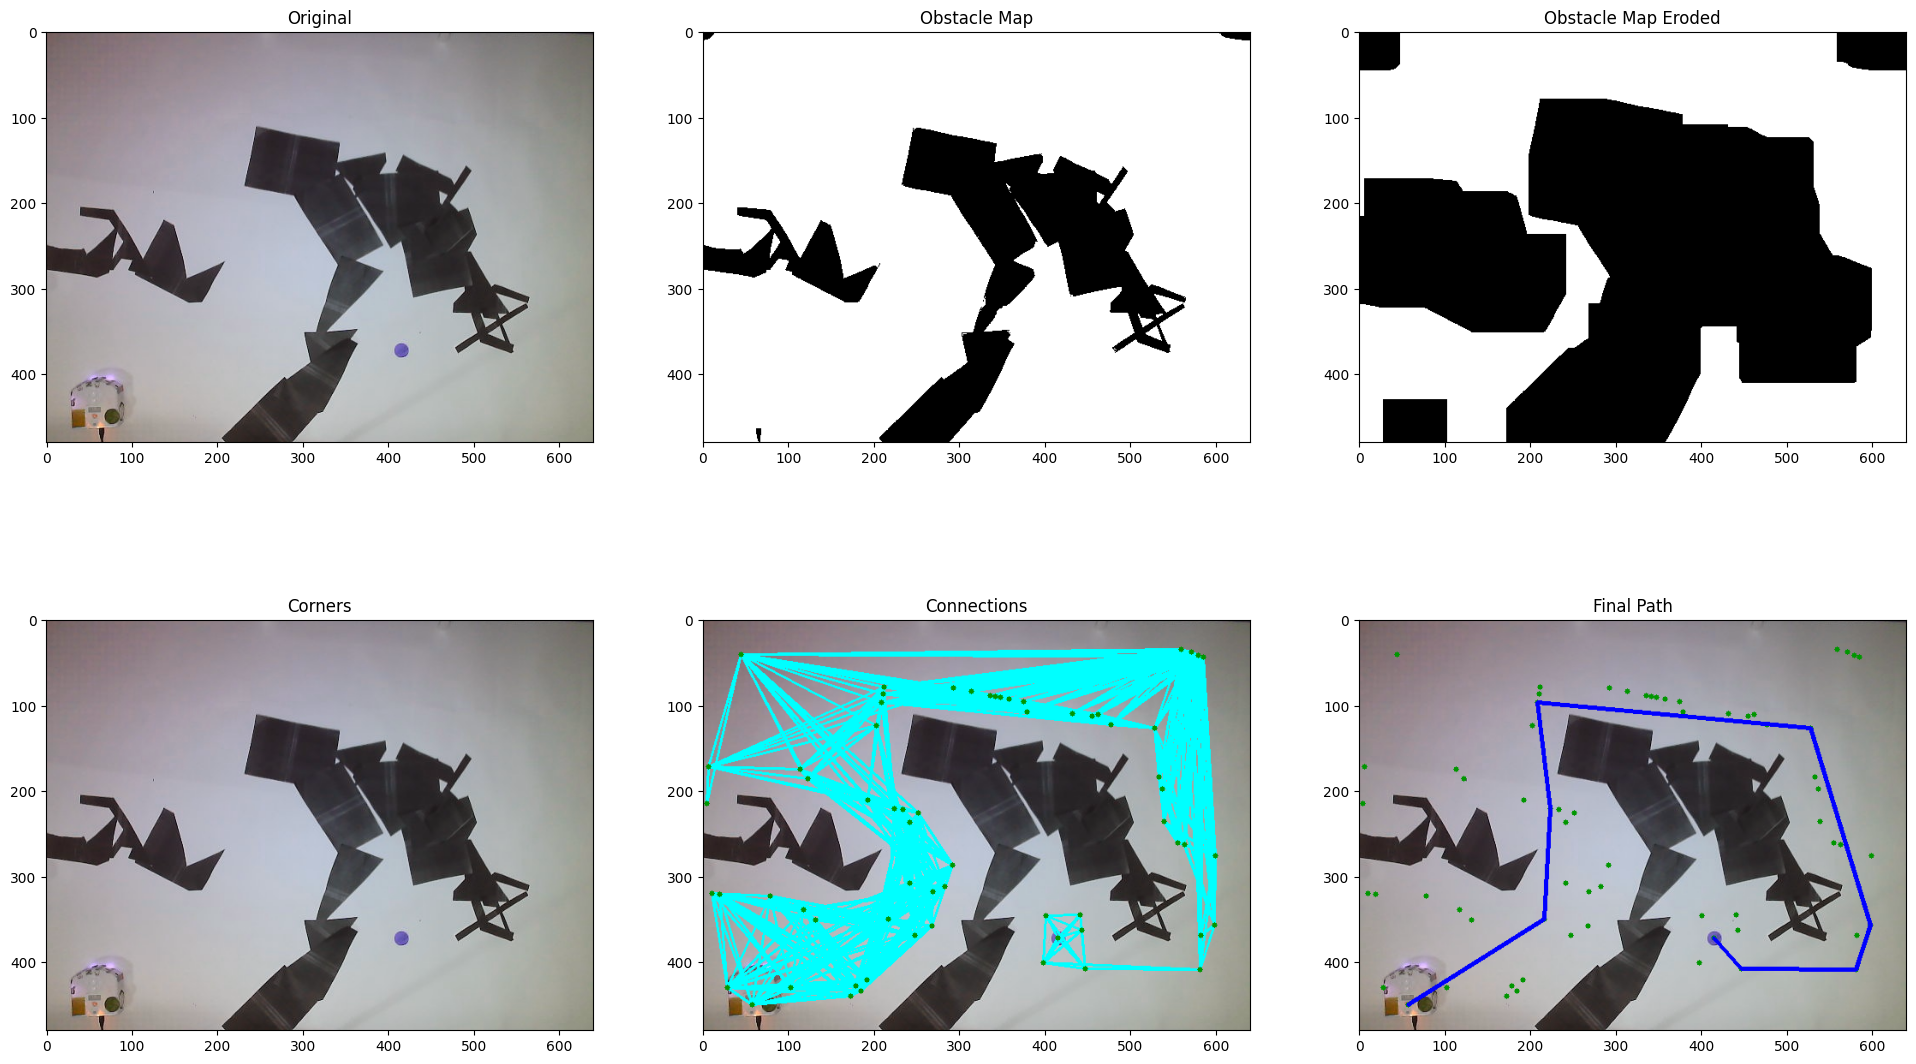

In [8]:
obstacle_map=find_obstacles(patched_img)
gray = np.float32(obstacle_map)

corners, gray_eroded=find_corners(gray, robot_coords, goal_coords, ERODE_FACTOR=70)
connections=connect_corners(corners, gray, ERODE_FACTOR=70, ERODE_FACTOR_CONNECTION_RATIO=0.3)
path=dijkstra(connections, robot_coords, goal_coords)

fig, ax = plt.subplots(2, 3, figsize=(24, 14))
corner_img=img.copy()
connection_img=img.copy()
for i in connections:
    for j in connections[i]:
        cv2.line(connection_img, i, j, (0,255,255), 2)
for i in corners:
    cv2.circle(corner_img, i, 3, (0,150,0), -1)
    cv2.circle(connection_img, i, 3, (0,150,0), -1)
ax[0][0].imshow(img)
ax[0][0].set_title('Original')
ax[0][1].imshow(obstacle_map, cmap='gray')
ax[0][1].set_title('Obstacle Map')
ax[0][2].imshow(gray_eroded, cmap='gray')
ax[0][2].set_title('Obstacle Map Eroded')
ax[1][0].imshow(img)
ax[1][0].set_title('Corners')
ax[1][1].imshow(connection_img)
ax[1][1].set_title('Connections')
for i in range(len(path)-1):
    cv2.line(corner_img, path[i], path[i+1], (0,0,255), 3)
ax[1][2].imshow(corner_img)
ax[1][2].set_title('Final Path')
plt.show()

## 3. Global Avoidance 

Once we have run the path finding algorithm and know where the robot is, we can get the robot to follow the path. With the environnement we set, we "simulated" a situation of a robot only being able to know it's position using external inputs (GPS for exemple) once stopped. 
The positioning is done via the camera using the `find_robot` function with a new image and then processed through an extended Kalman filter, described later in this document.

### Basic Robot Movement

However, this does not make the robot to move, for simplicity sake, we opted for a simple way of moving. The basic idea is to give the robot a certain speed for a certain amount of time. Measuring the elapsed time is crucial, and for that we used a threading function as shown hereafter. On a real-time based microcontroler, we would use an interrupt from a timer to get the most accurate timing. However, this is not possible in python. We therefore used threading, as described in [this answer][threading]. We calculate the time needed to go over a given distance, at a given speed. We then start the motor with said speed and start a timer that will call a function to stop the movement.

Here is an exemple of how this would work.


[threading]:https://stackoverflow.com/questions/3393612/run-certain-code-every-n-seconds


In [19]:
def stop_robot():
    global done_moving #we use a global varibale here, but in the catual code it is a class variable
    print("Stop the robot motion")
    done_moving=True

#Init function
motion_callback=RepeatedTimer.RepeatedTimer(None, stop_robot)

speed=50
distance=100

#this will make the function being called after 2 seconds
motion_callback.interval=distance/speed

#start the timer
done_moving=False
print("Start the robot motion")
motion_callback.start()
while not done_moving:
    #Doing other things, specifically local avoidance
    print("Looking out for objets in the way, ...")
    time.sleep(0.5)
motion_callback.stop()
print("Done")


Start the robot motion
Looking out for objets in the way, ...
Looking out for objets in the way, ...
Looking out for objets in the way, ...
Looking out for objets in the way, ...
Stop the robot motion
Done


To ease the robot movements, we used a two state finite state machine, switching rotation and translation. 

The process goes like this: once the robot has a goal, it turns towards it. Because of noise and imprecision, it often misses slightly the range of accepted angle (less than 3° in this project). If that is the case, the robot recomputes its position using the camera and the extended Kalman filter and starts again. We observed that for big angles (more than 100°), the robot misses it rarely by more than 5° which is sufficient.

After that, the robot starts moving forward towards the target. While doing this, we check for local avoidance, which is discussed later. Once it's done moving, the robot will stop, check its position, and if not in a small range, start with the rotation again. 

This process is iterated for each point composing the path found earlier until the end goal is reached. 

All of that is implemented in the main.py, which is detailed at the end. The flowchart of this is shown here:
<img src="images/main_graph.png">
<div style="text-align:center"> Global Navigation: Flowchart </div>

A problem encountered was how to translate the speed wanted on the ground, in pixels of the image, to the input speed of the motor. Using a few measurements and some experiment, we found there is a ratio of about 8/25 between the input of the motors and the speed in \[mm/s\]. However, the sizes given by the camera are in pixels, so to convert that, we used the disance between the two markers of the robot. It is easily measured on the image and using a device known as a ruler, we can measure the distance in mm in real life. We now have a way to convert from pixels measured to the speed input of the motors.

Note that an automatic control system, as simple as a proportional control, could have been used. However, this complicates the handling of time and distance measurements and the results obtained show that it is not worth it for this specific application. 

## 4. Local Navigation

Let us remind how the global navigation and the map are defined. The global obstacles, which are detected prior to path-planning, are made of flat black sheets of differents sizes and geometry. Once these obstacles are detected, the path is determined and the robot should not encounter them again. 

However, in case of an unfortunate deviation caused by a local obstacle, we do not want the robot to run over these "global obstacles". Therefore, the interest of having these black sheets is that they may also be recognized by the robot through sensors underneath itself. This provides great security regarding the coherence of the movements. But we'll get into more details later.

To simulate local obstacles, we chose randomly shaped and diverse 3D objects, to make use of the robot's front sensors. But in which case does the encounter between the robot and the local obstacle occur ? As we've seen previously, the robot follows a precise path, going from one point to the other, in a straight line. If an object, undetected before by the global avoidance, is placed on the robot route, he needs to be able to overcome this obstacle to finally reach his objective.

To work on these problematics, we decided to create the class `Local_Avoidance` (located in src) of three functions as follows :
* `__init__` : the constructor of the instance which initializes the following :
    * `self.th` : Thymio robot
    * `self.ur` : Instance of utilsRobot (explained in section VI). This is the same instance as the main so it is already initialized.
* `sawBlack` : Check if the robot sees black under him, using his bottom sensors
* `sawWall` : Check if the robot sees a wall in front of him, using his front sensors
* `avoid_obstacle` : Function to actually avoid the obstacle

As seen before, the robot needs to be permanently aware that he might encounter an undesired object when he's moving straight. And that's exatly how we proceed. In the `main.py` module, in the `while` performing the forward movement behavior (line 119), at each iteration, the functions `sawBlack` and `sawWall` are called, to check whether or not an obstacle is encountered. If so, we get to the function `avoid_obstacle`. 

It is designed as such : 
* First, it is tested if the robot saw black underneath it, if it does, it turns 180° to change path. If it does not see black :
    * A `while` loop is controlling the avoidance of an obstacle : while the robot sees a wall, it keeps turning accordingly. The rate of the turning is determined by taking into account the value of the front sensors and summing them with weights. The weights have been determined proportionnally to the proximity of the sensor to the left or right wheel. Here is the resulting equation :
    $[l_{speed}, r_{speed}] = 0.1\times\begin{bmatrix}s_1 & s_2 & s_3 & s_4 & s_5\end{bmatrix}\cdot\begin{bmatrix}1 & -1\\ 1/2 & -1/2 \\ -1/4 & 1/4 \\ -1/2 & 1/2 \\ -1 & 1\end{bmatrix}+rob_{speed}$
    Where $s_x$ are the values of the sensors. 
* Once the robot has turned enough, he tries to get away from the obstacle by moving in the direction he's facing for 4 seconds.

Here is an illustrated version of the logic applied to the `local_avoidance` algorithm :

### Step 1:

<img src="images/LA_1.jpg" width=50%>

### Step 2:

<img src="images/LA_2.jpg" width=50%>

### Step 3:

<img src="images/LA_3.jpg" width=50%>

We saw one more possible improvement in this method: the robot going straight in his defined angle would take him far away from his objective. Therefore, we'd want the robot to show a slow curve to recover its trajectory. That's what is done in the last part of the algorithm. We start by setting a differential speed on the two wheels. This speed difference is slowly balanced back in order for the robot to first make a slow turn and then do a small bit as a straight line.

Once these two operations are done, we get back to the `main` algorithm and to a normal behavior. If another object is encountered, the whole `avoid_obstacle` function is back again.

All these operations will be demonstrated in the `main` part, later in this document.

## 5. Extended Kalman Filter
We decided to implement a complete extended Kalman Filter to our Motion Control routine. It takes the motion control vector u and previous system state vector estimations Mu and Sigma in order to combine and filter the predicted state vector based on the inputed motion controls and the measured state vector based on camera data.The entire algorithm follows the instructions given throughout the BMR [course][EKF_course] with some additional information provided from [external sources][EKF].  
The filter assumes a 5 variable system state that is designed to be complete, that is to say it holds all the information usefull to predict the following state for a designated time frame, provided the motor control inputs did not change. To be precise, this included:
* x coordinate in pixels
* y coordinate in pixels
* theta angle in rad (the robot angle with relation to the picture frame referentiel)
* v the linear speed of the robot in pxls/s
* theta_dot the angular speed in rad/s  
  
The main challenge of the Extended Kalman Filter was determining the Covariance noise matrices and then the implementation within the main function. Also, we realized too late in the development of the filter that we really did not need so many parameters to correctly control the Thymio. A complete state vector is nice, but we really only needed the x, y and theta measurements in order to correct our expected position. This reduction in complexity would have facilitated the implementation of the filter and possibly allowed us to use it more frequently. Currently, it is only useful to correct the global avoidance steps after straight line mouvement and angle rotations. It is not currently used during our local avoidance, since local avoidance does not have a fixed motor speed rotation during a set time, which is a definite weak point of our project as a whole.  
  
It is important to note that the usefulness of the Kalman filter was never completely clear, because our preliminary tests using just the camera for positioning proved to not cause too many issues or justify the need for a filter. This is because the nature of our setup allows for constant image tracking of the robot, so we never needed to rely on only the motor control inputs to predict where the thymio actually was. Once the Kalman filter was correctly implemented into the code, we decided to retro-fit the robot localization model to only consider the kalman filter outputs. This choice was simply to make the filter more useful in our project, but was seemingly unecessary to achieve the primary goal of local and global avoidance.

[EKF_py]:https://github.com/Nchennoufi/MobileRobotrics/blob/main/Extended_Kalman_Filter.py
[EKF_course]:https://moodle.epfl.ch/pluginfile.php/2715133/mod_resource/content/7/Slides%2007_08%20-%20Uncertainties%20-%202.pdf
[EKF]:https://en.wikipedia.org/wiki/Extended_Kalman_filter


**Constants** : for the notebook implementation presented here, we needed to remove class parameters and add some constants. It is important to note that the R and Q noise matrices were difficult to estimate and went through several variations, include some where they depended on the time between measurements. Here they were fixed to these covariances, found in series 8 of the course to simplify our calculations and filter corrections.

In [10]:
pxl_var = 0.25
H = np.eye(5)          #technically jacobian of h(x), the camera measurements function
R = np.diag([pxl_var,  # variance of location on x-axis in pxl^2
            pxl_var,   # variance of location on x-axis in pxl^2
            0,         # variance of yaw angle          in rad^2
            6.15,      # variance of velocity           in pxl^2/s^2
            0])        # variance of angular velocity   in rad^2/s^2(yaw rate)
    
Q = np.diag([0.04,    # variance of location on x-axis in pxl^2
             0.04,    # variance of location on y-axis in pxl^2
             0,       # variance of yaw angle          in rad^2
             6.15,    # variance of velocity           in pxl^2/s^2
             0])      # variance of angular velocity   in rad^2/s^2(yaw rate)


`capture_measurements` is not used in this notebook, but is the function used in the full main.py that takes the current image measurements defined by the camera image processing and compares them to the previous estimated state vector data stored in Mu. For demonstration purposes in this notebook we will simply imput a previously calculated y vector calculated during a full code demonstration.

In [11]:
def capture_measurements(Mu,ur,dt):
    '''
    Function that takes a picture and analyses the data to return the current measurement state vector.

    Inputs: - Mu : The previous mesurement time's mean system state values.
               1x5 vector that holds the current axis coordinates, angle,
               velocity and angular velocity estimations.

    Output: - y_current : The current measured system state values based on observation values
                          1x5 vector that holds the current axis coordinates, angle,
                          velocity and angular velocity mesurements.
    '''
    y=np.zeros(5).T
    y[0] = ur.coords[0]
    y[1] = ur.coords[1]
    y[2] = ur.angle
    y[3] = math.sqrt((y[0]-Mu[0])**2+(y[1]-Mu[1])**2)/dt
    y[4] = (y[2]-Mu[2])/dt
    y_current = measure_state(y)
    return y_current

`u_input` is not used in this notebook either, but we wanted to show how we turn the motor speed data from the left and right wheels into the motor control vector that expresses the linear speed and angular speed. The scaling factor used here is the same as the one defined in our Global Avoidance functions as determined by the distance between the two identifier dots and the actual distance. It is updated everytime we take a picture in order to account for the angle between the camera and the Thymio.

In [12]:
def u_input(speed_l,speed_r, wheel_distance, scaling_factor):
    '''
    Function that takes the raw speed values of each wheel motor and converts it into
    translation speed and rotation speed with a pixel scaling factor.

    Inputs: - speed_l: speed of left motor in mm/s
            - speed_r: speed of right motor in mm/s
            - scaling_factor : in pxl/mm

    Output: - u  : The current motor control values.
                   1x2 vector that holds current inputed speed and angular velocity.
                   in pxl/s and rad/s
    '''
    v = scaling_factor * (speed_r + speed_l)/2
    theta_dot = (speed_r - speed_l)/WHEEL_DISTANCE
    u = np.array([v, theta_dot]).T
    return u

The below function is simply used to apply the varying time difference between measurements to the current motor control vector values according to the Jacobian of the process state function we call `thymio_state`.

In [13]:
def jacobian_G(theta, v):
    '''
        Function that returns the Jacobian of the thymio state function applied to the previous system state estimations.

        Inputs: - theta : the current estimated Thymio angle in rad
                - v  : The current motor control speed in pxl/s

        Output: - 
    '''
    G = np.array([[1,0,-dt*v*math.sin(theta),dt*math.cos(theta),0],
                 [0,1, dt*v*math.cos(theta),dt*math.sin(theta),0],
                 [0,0,1,0,dt],
                 [0,0,0,1,0],
                 [0,0,0,0,1]])
    return G

The `measure_state` function is used in both the calculation of the measured state vector, where it adds the covariance error, and also within the calculation of the estimated current step Sigma value. Note that the C matrix is simply the identity matrix, which is why the H matrix used un the `extended_kalman` function is also defined as a constant identity matrix. 

In [14]:
def measure_state(x):
    '''
    Function that returns the current measured state values depending on previous system state values
    and current input motor control vector.

    Inputs: - x : The previous mesurement time's mean system state values.
                  1x5 vector that holds the current axis coordinates, angle,
                  velocity and angular velocity estimations/observations.

    Outputs: - y : The current measured system state values based on observation values
                   1x5 vector that holds the current axis coordinates, angle,
                   velocity and angular velocity mesurements.
    '''
    C = np.eye(5)
    y = np.dot(C,x) + np.diag(R)
    return y

The `thymio_state` function is used to predict the next system state mean values based on previous mean values of the last measurement and on the current motor control input vector. This function is a combination of both sources of Extended Kalman Filter information and teh course information. As such we have named and designed our A and B functions that effect the previous estimated state vector and the current motor control vector to predict the next state vector according to the internal thymio precess. To complete the Kalman filter, we then need to take the jacobian of the equivilant matrix function, as defined in the `jacobian_G` function.

In [15]:
def thymio_state(u, Mu):
    '''
    Function that returns the current system state values depending on previous system state values
    and current input motor control vector.

    Inputs: - Mu : The previous mesurement time's mean system state values.
                   1x5 vector that holds the current axis coordinates, angle,
                   velocity and angular velocity estimations.
            - u  : The current motor control values.
                   1x2 vector that holds current inputed speed and angular velocity.

    Outputs: -Mu_pred : The current predicted system state values based on previous values
                        and current input motor control data.
    '''
    theta = Mu[2]
    A = np.eye(5)*np.array([1,1,1,0,0])
    B = np.array([[dt*math.cos(theta),0],
                 [dt*math.sin(theta),0],
                 [0,dt],
                 [1,0],
                 [0,1]])
    Mu_pred = np.dot(A,Mu) + np.dot(B,u) + np.diag(Q)
    return Mu_pred

`extended_kalman` is the main function that operates the extended Kalman filter we have desgined. It follows exactly the logical steps of the algorithm as defined in the course, even if in some cases (like for the H matrix or the S matrix) no change is actually really happening during these lines of code, but in order to stay consistent with the theory, we implemented them anywas. Notably there is no calculation of Q for the current time difference `dt` because time constraints made us simplify our noise covariance matrices, and Q is now a constant.

In [16]:
def extended_kalman(Mu, Sigma, u, y,dt):
    '''
    Function that takes the previous mean and covariance estimations and Applies an extended Kalman Filter.
    It incorporates the camera mesurements and motor controls to find the current Kalman gain.
    Kalman gain is then used to correct system state estimations.

    Inputs: - Mu    : The previous mesurement time's mean system state values.
                      1x5 vector that holds the current axis coordinates, angle,
                      velocity and angular velocity estimations.
            - Sigma : The previous measurement time's Covariance matrix.
                      5x5 matrix and holds each the covariance values of the previous estimations.
            - u     : The current motor control values.
                      1x2 vector that holds current inputed speed and angular velocity.
            - y     : The current system camera measurements.
                      1x5 vector that holds measured axis coordinates, angle based on camera measurements,
                      as well as the velocity and angular velocity based on previous velocity estimations.
            - dt    : Time difference between previous and current Kalman Filter measurements

    Outputs: - Mu_est    : The current estimated mean system state values, after Kalman filtering.
                           1x5 vector that holds the same data types as the input Mu.
             - Sigma_est : The current estimated System Covariance matrix.
                           5x5 matrix that holds each covariance value of current state estimations.
    '''
    epsilon = np.eye(5)*(1e-5) #small value needed to stabalize the covariance matrix and insure S is invertable

    #Predict values
    Mu_pred = thymio_state(u, Mu)
    G = jacobian_G(Mu[2], u[0])
    Sigma_pred = np.dot(G,np.dot(Sigma,G.T)) + Q

    #Calculate Kalman Gain
    S = np.dot(np.dot(H,Sigma_pred),H.T) + R
    K = np.dot(Sigma_pred,np.dot(H.T,np.linalg.inv(S)))

    #Update Estimated values
    Mu_est = Mu_pred + np.dot(K,(y - measure_state(Mu_pred)))
    Sigma_est = np.dot((np.eye(5)-np.dot(K,H)),Sigma_pred) + epsilon
    Mu, Sigma = Mu_est, Sigma_est
    return Mu,Sigma

**Simulation Example :**  
Here we have a simple example of our Kalman filter in action. The inputed data is taken directly from running the course which is shown in the images below.  
As you can see our filter corrects the robot position from it's expected position (the goal coordinates) and feedsback the actual position as taken from the previous system state vector Mu, the motor control vector u and the current measured state vector as seen by the camera y. All these input variables are given numerical here.

In [17]:
dt = 1              #[s]
input_speed = 14    #[mm/s]

Mu = np.array([1,2,120,0,0])
Sigma = np.eye(5)
y = np.array([122,289,121,0,0])
u =np.array([10,0.02])
goal = np.array([120, 290])
print("Pre-filtering expected position : x: ", goal[0]," y: ", goal[1])

Mu,Sigma = extended_kalman(Mu, Sigma, u, y,dt)
print("Post-filtering estimated position : x: ", Mu[0]," y: ", Mu[1])

Pre-filtering expected position : x:  120  y:  290
Post-filtering estimated position : x:  115.43919678359194  y:  247.74833422710373


The resulting correction is visible as we can see here:

<img src="images\Thymio Axis.jpg" width=50%>

The actual post and pre-filtering data are given here:
<img src="images\Thymio Axis.jpg" width=50%>
<img src="images\Thymio Axis.jpg" width=50%>

## 6. Motion Control

We actually thought a lot about motion control since it is a very sensible and essential part of the project : if the robot does not move right, any effort put anywhere else is useless.

First, before trying to implement the filter, we decided to compute the coordinates and angle of the robot using its speed and time, which can lead to a lot of uncertainties that had to be dealt with. We then have put the camera on and computed the coordinates using two pasties on the robot. 

After doing all that, we could notice improvements but still a lot of uncertainties.

Finally, we implemented the extended Kalman filter which improved a lot motion control ! Movement of the robot then used computations over time and camera analysis. The whole was filtered using the extended Kalman filter that improved a lot uncertainties.

We ended up with a precise localisation and motion control system that permits us to navigate easily towards our goal.

Motion control is everywhere, useful in each class and module. Thus, we decided to create a class `utilsRobot` which contains the following methods :
* `__init__` : the constructor of a utilsRobot instance which initializes the following :
    * `self.th` : Thymio robot.
    * `self.angle` : Angle of the robot, initialized to 0.
    * `self.coords` : Coordinates of the robot, initialized to (0,0).
    * `self.speed` : Speed of the robot, initialized to 0.
    * `self.center_red` : Center of the red pastie on the robot (used to locate it and compute the angle)
    * `self.center_green` : Center of the green pastie on the robot (used to locate it and compute the angle)
    * `self.time_stamp` : time.time() to get the start time of the simulation.
    * `self.scaling_factor` : Scaling factor for the image, initialized to 1.
    * `self.scaled_robot_length` : Multiplication of the previous attributes to get the length of the robot on the map
        * `self.scaled_robot_length` = `self.scaling_factor`*`self.ROBOT_LENGTH`
    * `self.stop()` : Call of the function `self.stop() in order to ensure that the robot is motionless.
* `get_current_speed` : Returns the speed of the robot
* `move` : Get the robot to move ! The user has to specify right and left speed for each wheel of the robot.
* `stop` : Stops the robot from any movement.
* `go_straight` : Get the robot to move forward.
* `turn_angle` : Decides at which angle the robot should turn.
* `find_robot` : Find the robot on the map.
* `find_delta_angle` : Find the difference between the robot angle and the next goal angle.
* `image_pixel_scale` : Scaling of the image to convert pixels into real distance.
* `increment_motor` : Increment the speed of one wheel of the robot by a certain value.

## 7. Main 

Now we arrive to the main section, we get to execute all the work done until then.
    
First, let's start our Thymio ! Let us remind that Thymio is a fellow lost festival-goer at Balélec. He's coming up right at the gates and can't wait to see his friends. "We're in front of the Grande Scène" they said. It shouldn't be that hard to find.

In [18]:
print(">> Starting Thymio")

th = Thymio.serial(port="COM7", refreshing_rate=0.1) #Put your USB modem right
time.sleep(0.5) #Making sure Thymio has time to connect
th.set_var_array("leds.top",[0,0,0])
th.set_var_array('leds.bottom.right',[0,0,0])
th.set_var_array('leds.bottom.left',[0,0,0])
th.set_var_array("leds.circle",[0,0,0])

>> Starting Thymio


SerialException: could not open port 'COM7': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)

To locate his friends, Thymio must first start his camera :

In [ ]:
print(">> Starting Camera")
cam=camera.Camera()

Before starting to move towards his friends, Thymio must initialize the instances needed from other classes and take a picture of the map :

In [ ]:
print(">> Initializing variables")
GA = global_avoidance.Global_Avoidance()
ur = utilsRobot.utilsRobot(thymio=th)
la = local_avoidance.Local_Avoidance(th, ur)

GA.map=cam.take_picture()

Almost everything is now set up, Thymio can locate his goal, himself (which will obviously be our starting point) and his path !

*Disclaimer : If one of those 3 elements are not found, the program will stop ...*

In [ ]:
print(">> Searching for goal")
if not GA.find_goal(GA.map):
    print("ERROR: Could not find goal")
    th.close()
    cam.destroy()
    sys.exit()

print(">> Searching for robot")
success, ur.coords, ur.angle, GA.patched_map = ur.find_robot(GA.patched_map)
if not success:
    print("ERROR: Could not find robot")
    th.close()
    cam.destroy()
    sys.exit()
GA.start_coords=ur.coords
ur.image_pixel_scale()

print(">> Searching for path")
GA.find_obstacles(GA.patched_map)
if not GA.find_path():
    print("ERROR: Could not find path")
    th.close()
    cam.destroy()
    sys.exit()
GA.display_path(GA.map, robot_coords=ur.coords, freeze=True, path=True, connections=True, corners=True)
GA.path.pop(0)

To smoothen things up, Thymio initializes his filter as well as his threading function

In [ ]:
print(">> Initializing filter")
EKF = Extended_Kalman_Filter.Extended_Kalman_Filter()
EKF.Sigma = np.eye(5)
EKF.Mu = [ur.coords[0],ur.coords[1],ur.angle,0,0]
EKF.input_speed=CALIBRATE_FACTOR*50

print(">> Initializing threading functions")
motion_callback=RepeatedTimer.RepeatedTimer(None, ur.stop)
increment_callback=RepeatedTimer.RepeatedTimer(0.1, ur.increment_motor, la.side, LA_INCREMENT)


Now let's cut the chase, Thymio must find his friends before the beginning of the next concert !
    
Here is the loop that will get our poor lost robot to find its goal :

In [ ]:
for goal in GA.path:
    print(">>> Aiming towards ",goal)
    while ((goal[1]-ur.coords[1])**2+(goal[0]-ur.coords[0])**2)**0.5>DISTANCE_TOL: #Euclidian norm between the robot and the first goal
        goal_angle=math.atan2((goal[1]-ur.coords[1]),(goal[0]-ur.coords[0]))
        delta_angle=ur.find_delta_angle(ur.angle,goal_angle)

        print(">>> Robot estimated position: x:{:.2f}, y:{:.2f} angle:{:.2f}".format(ur.coords[0], ur.coords[1], ur.angle))

        print("    Distance from goal: {:.2f}, angle to goal: {:.2f}".format(((goal[1]-ur.coords[1])**2+(goal[0]-ur.coords[0])**2)**0.5, delta_angle*180/math.pi))
        while abs(delta_angle)>ANGLE_TOL:
            EKF.Mu = [ur.coords[0],ur.coords[1],ur.angle,0,0]

            motion_callback.interval, direction=ur.turn_angle(delta_angle, TURNING_SPEED)
            motion_callback.start()
            u=EKF.u_input(-direction*TURNING_SPEED*CALIBRATE_FACTOR,-direction*TURNING_SPEED*CALIBRATE_FACTOR, DISTANCE_WHEELS,ur.scaling_factor)

            while not ur.done_moving:
                continue
            motion_callback.stop()

            img=cam.take_picture()
            _, ur.coords, ur.angle,_=ur.find_robot(img)
            print(">>> Filtering")
            EKF.dt = time.time()-ur.time_stamp
            EKF.extended_kalman(u,EKF.capture_measurements(ur))
            ur.coords, ur.angle = (EKF.Mu[0],EKF.Mu[1]), EKF.Mu[2]
            print("    Result: \tPre filter: angle:{:.2f}\n\t\tPost filter: angle:{:.2f}".format(goal_angle,ur.angle))

            goal_angle=math.atan2((goal[1]-ur.coords[1]),(goal[0]-ur.coords[0]))
            delta_angle=ur.find_delta_angle(ur.angle,goal_angle)

        EKF.Mu = [ur.coords[0],ur.coords[1],ur.angle,0,0]
        u=EKF.u_input(FORWARD_SPEED*CALIBRATE_FACTOR,FORWARD_SPEED*CALIBRATE_FACTOR, DISTANCE_WHEELS,ur.scaling_factor)

        new_state="none"
        motion_callback.interval=ur.go_straight(((goal[1]-ur.coords[1])**2+(goal[0]-ur.coords[0])**2)**0.5, FORWARD_SPEED)
        motion_callback.start()
        while not ur.done_moving:
            time.sleep(0.001)
            if la.sawWall() or la.sawBlack():
                ur.stop()
                motion_callback.stop()
                increment_callback.stop()
                print("!!! Obstacle detected, switching to local avoidance")
                time.sleep(0.2)
                new_state="avoid"
                la.avoid_obstacle(LA_SPEED, new_state, motion_callback, increment_callback)

        motion_callback.stop()
        increment_callback.stop()

        img=cam.take_picture()
        _, ur.coords, ur.angle,_=ur.find_robot(img)
        if new_state=="none":
            print(">>> Filtering")
            EKF.dt = time.time()-ur.time_stamp
            EKF.extended_kalman(u,EKF.capture_measurements(ur))

            ur.coords, ur.angle = (EKF.Mu[0],EKF.Mu[1]), EKF.Mu[2]
            print("    Result: \tPre filter: x:{:.2f} y:{:.2f}\n\t\tPost filter: x:{:.2f} y:{:.2f}".format(goal[0], goal[1], ur.coords[0], ur.coords[1]))
            GA.display_path(img, robot_coords=goal, est_robot_coords=ur.coords, freeze=False, path=False)
        else:
            print("!!! Searching for goal")
            EKF.Mu = [ur.coords[0],ur.coords[1],ur.angle,0,0]

        EKF.scaling_factor=ur.image_pixel_scale()


    print(">>> Arrived at ", goal)

ur.stop()
print(">>> Arrived at destination")

We finally made it ! Thymio has arrived to the goal, now we must tell him that his quest is over ! He has found his friends who are "right next to the grande scène" and he can now dance all night long and finally have a good time.   

In [ ]:
th.close()
cam.destroy()

## 8. Conclusion

To sum things up, we managed to make a robot move from its starting point to a goal in a chaotic environment made of non-regular flat obstacles on the ground while avoiding 3D objects put randomly on his way.

To do so, we used global navigation to find the shortest path to the goal, local navigation to avoid obstacles and vision implementation through an extended Kalman filter to estimate the robot position and resulting needed motor controls.

Unfortunately, we could not manage to reproduce Festival Balélec's map, however we kept the chaos a random attendee would find trying to reach his friend, or food or a concert. We reproduced that chaos through randomly disposed obstacles with irregular shapes (which is actually challenging for our global navigation, but it was worth the effort).

While the road to finish this project was paved with imaginary obstacles, we avoided them to finally come to terms with it even if chaos was also a part of our organization...
   